<a href="https://colab.research.google.com/github/maki8maki/DLBasics2023_colab/blob/master/lecture02_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第2回講義 宿題

## 課題
今回のLessonで学んだことを元に，MNISTのファッション版 (Fashion MNIST，クラス数10) をソフトマックス回帰によって分類してみましょう．

Fashion MNISTの詳細については以下のリンクを参考にしてください．

Fashion MNIST: https://github.com/zalandoresearch/fashion-mnist

### 目標値
Accuracy: 80%

### ルール
- **下のセルで指定されている`x_train、y_train`以外の学習データは使わないでください．**
- **ソフトマックス回帰のアルゴリズム部分の実装はnumpyのみで行ってください** (sklearnやtensorflowなどは使用しないでください)．
    - データの前処理部分でsklearnの関数を使う (例えば `sklearn.model_selection.train_test_split`) のは問題ありません．

### 提出方法
- 2つのファイルを提出していただきます．
    1. テストデータ (`x_test`) に対する予測ラベルを`submission_pred.csv`として保存し，**Homeworkタブから`lecture02`を選択して**提出してください．
    2. それに対応するpythonのコードを`submission_code.py`として保存し，**Homeworkタブから`lecture02 (code)`を選択して**提出してください．
      
- なお，採点は1で行い，2はコードの確認用として利用します（成績優秀者はコード内容を公開させていただくかもしれません）．コードの内容を変更した場合は，**1と2の両方を提出し直してください**．

### 評価方法
- 予測ラベルの`y_test`に対する精度 (Accuracy) で評価します．
- 即時採点しLeader Boardを更新します．（採点スケジュールは別アナウンス）
- 締切後の点数を最終的な評価とします．

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### データの読み込み（このセルは修正しないでください）

In [2]:
import os
import sys

import numpy as np
import pandas as pd

sys.modules['tensorflow'] = None

def load_fashionmnist():
    # 学習データ
    x_train = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Lecture02/data/x_train.npy')
    y_train = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Lecture02/data/y_train.npy')
    
    # テストデータ
    x_test = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Lecture02/data/x_test.npy')
    
    x_train = x_train.reshape(-1, 784).astype('float32') / 255
    y_train = np.eye(10)[y_train.astype('int32')]
    x_test = x_test.reshape(-1, 784).astype('float32') / 255
    
    return x_train, y_train, x_test

### ソフトマックス回帰の実装

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

x_train, y_train, x_test = load_fashionmnist()

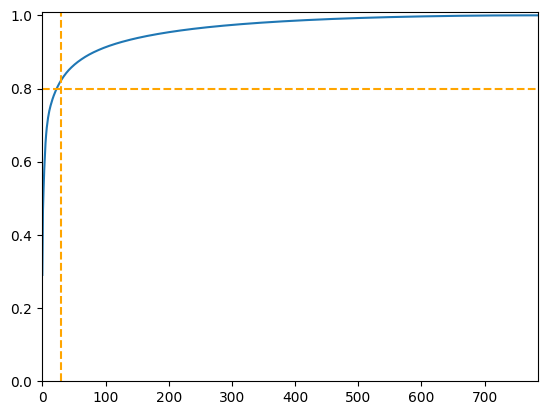

In [8]:
S = np.cov(x_train.T, bias=True) # 分散共分散行列
eig, eigvec = np.linalg.eig(S) # 固有値, 固有ベクトル

# 昇順に並べ替え
idx = np.argsort(eig)[::-1]
eig = eig[idx]
eigvec = eigvec[idx]

# 主成分をどこまで考慮するか判断するためのグラフ表示
import matplotlib.pyplot as plt

plt.plot(np.arange(len(eig)), [sum(eig[0:i+1]/sum(eig)) for i in range(len(eig))])
plt.xlim(-1, len(eig))
plt.ylim(0, 1.01)
plt.axvline(x = 30, ls="dashed", color="orange")
plt.axhline(y = 0.8, ls="dashed", color="orange")

In [9]:
n_pc = 100 # 考慮する主成分の数
x_train_pc, x_test_pc = np.dot(x_train, eigvec[0:n_pc].T), np.dot(x_test, eigvec[0:n_pc].T)

# weights
W = np.random.uniform(low=-0.08, high=0.08, size=(n_pc, 10)).astype('float32')
b = np.zeros(shape=(10,)).astype('float32')

In [6]:
def np_log(x):
    return np.log(np.clip(a=x, a_min=1e-10, a_max=1e+10))

def softmax(x, axis=1):
    x -= x.max(axis, keepdims=True)
    x_exp = np.exp(x)
    return x_exp / x_exp.sum(axis, keepdims=True)

def train(x, y, eps=1.0):
    """
    :param x: np.ndarray, 入力データ, shape=(batch_size, 入力の次元数)
    :param y: np.ndarray, 教師ラベル, shape=(batch_size, 出力の次元数)
    :param eps: float, 学習率
    """
    global W, b
    
    batch_size = x.shape[0]
    
    # 予測 shape: (batch_size, 出力の次元数)
    y_hat = softmax(np.matmul(x, W) + b)
    
    # 目的関数
    cost = -(y * np_log(y_hat)).sum(axis=1).mean()
    
    delta = y_hat - y # shape: (batch_size, 出力の次元数)
    
    # パラメータの更新
    dW = np.matmul(x.T, delta) / batch_size # shape: (入力の次元数, 出力の次元数)
    db = np.matmul(np.ones(shape=(batch_size,)), delta) / batch_size # shape: (出力の次元数,)
    W -= eps * dW
    b -= eps * db

    return cost

def valid(x, y):
    y_hat = softmax(np.matmul(x, W) + b)
    cost = (- y * np_log(y_hat)).sum(axis=1).mean()
    
    return cost, y_hat

In [12]:
import random

num_epoch = 1000 # epoch数
dig = num_epoch / 10 # 学習経過の表示に利用
cost_train = 10.0 # 初期コスト
batch_size = int(len(x_train_pc) * 0.1) # ミニバッチとして取り出す量
num_k = 5
for k in range(num_k):
  #　訓練データと検証データを変えてパラメータ更新
  x_train_k, x_valid_k, y_train_k, y_valid_k = train_test_split(x_train_pc, y_train, test_size=0.1)
  for epoch in range(num_epoch):
      # オンライン学習
      idxs = random.sample(range(len(x_train_k)), k=batch_size)
      cost_train = train(x_train_k[idxs], y_train_k[idxs], cost_train*2) # costにあわせて学習率を変更
      cost_valid, y_pred = valid(x_valid_k, y_valid_k)
      if epoch % dig == (dig-1) or epoch == 0:
          print('EPOCH: {}, Valid Cost: {:.3f}, Valid Accuracy: {:.3f}'.format(
              epoch + 1,
              cost_valid,
              accuracy_score(y_valid_k.argmax(axis=1), y_pred.argmax(axis=1))
          ))

y_pred = softmax(np.matmul(x_test_pc, W) + b).argmax(axis=1)

submission = pd.Series(y_pred, name='label')
submission.to_csv('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Lecture02/submission_pred.csv', header=True, index_label='id')

EPOCH: 1, Valid Cost: 0.593, Valid Accuracy: 0.791
EPOCH: 100, Valid Cost: 0.526, Valid Accuracy: 0.821
EPOCH: 200, Valid Cost: 0.527, Valid Accuracy: 0.820
EPOCH: 300, Valid Cost: 0.527, Valid Accuracy: 0.821
EPOCH: 400, Valid Cost: 0.527, Valid Accuracy: 0.819
EPOCH: 500, Valid Cost: 0.527, Valid Accuracy: 0.821
EPOCH: 600, Valid Cost: 0.527, Valid Accuracy: 0.820
EPOCH: 700, Valid Cost: 0.527, Valid Accuracy: 0.818
EPOCH: 800, Valid Cost: 0.528, Valid Accuracy: 0.819


KeyboardInterrupt: ignored